<a href="https://colab.research.google.com/github/MaakAdityaGupta/localRepo/blob/main/V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V2 version

In [ ]:
#1
!pip -q install lightgbm pandas numpy scikit-learn joblib openpyxl

In [ ]:
#2
import os
import math
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
#3
# ===== V2 FOLDER SETUP =====
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/antenna_ml/V2'
MODEL_DIR = f'{BASE_DIR}/models'
DATA_DIR  = f'{BASE_DIR}/data'

import os
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("Using V2 folder:", BASE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using V2 folder: /content/drive/MyDrive/antenna_ml/V2


In [ ]:
#4
DATA_PATH = f"{DATA_DIR}/antenna_dataset.csv"
df = pd.read_csv(DATA_PATH)

# FIX: remove extra spaces from column names immediately after reading
df.columns = df.columns.str.strip()

df = df.groupby(
    ["Tx_Lat","Tx_Lon","RX_Lat","RX_Lon","RX_Rotation_deg",
     "TX_Sector","TX_Element","RX_Sector","RX_Element","Frequency_Hz"],
    as_index=False
)["SNR_dB"].max()


In [ ]:
#5 Convert rotation degrees to radians
rot_rad = np.deg2rad(df["RX_Rotation_deg"].values)

df["RX_rot_sin"] = np.sin(rot_rad)
df["RX_rot_cos"] = np.cos(rot_rad)

df.head()

,Tx_Lat,Tx_Lon,RX_Lat,RX_Lon,RX_Rotation_deg,TX_Sector,TX_Element,RX_Sector,RX_Element,Frequency_Hz,SNR_dB,RX_rot_sin,RX_rot_cos
0,30.968764,76.474704,30.968895,76.474175,0,1,1,1,1,5200000000,32.466354,0.0,1.0
1,30.968764,76.474704,30.968895,76.474175,0,1,1,1,1,5260000000,28.429306,0.0,1.0
2,30.968764,76.474704,30.968895,76.474175,0,1,1,1,1,5320000000,-6.736144,0.0,1.0
3,30.968764,76.474704,30.968895,76.474175,0,1,1,1,1,5380000000,29.755014,0.0,1.0
4,30.968764,76.474704,30.968895,76.474175,0,1,1,1,1,5440000000,31.539402,0.0,1.0


In [ ]:
#6
from sklearn.model_selection import GroupShuffleSplit

#1) Group key = same (RX_Lat, RX_Lon, RX_Rotation_deg)
df["group_key"] = (
    df["RX_Lat"].astype(str) + "_" +
    df["RX_Lon"].astype(str) + "_" +
    df["RX_Rotation_deg"].astype(str)
)

groups = df["group_key"]

#2) train+val vs test (group-wise)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(gss1.split(df, groups=groups))

trainval_df = df.iloc[trainval_idx].copy()
test_df     = df.iloc[test_idx].copy()

#3) train vs val (group-wise)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss2.split(trainval_df, groups=trainval_df["group_key"]))

train_df = trainval_df.iloc[train_idx].copy()
val_df   = trainval_df.iloc[val_idx].copy()

print("Train rows:", train_df.shape)
print("Val rows  :", val_df.shape)
print("Test rows :", test_df.shape)

print("Unique groups:")
print("Train:", train_df["group_key"].nunique())
print("Val  :", val_df["group_key"].nunique())
print("Test :", test_df["group_key"].nunique())

#sanity check: overlap should be 0
print("\nOverlap check:")
print("Train∩Val :", len(set(train_df["group_key"]) & set(val_df["group_key"])))
print("Train∩Test:", len(set(train_df["group_key"]) & set(test_df["group_key"])))
print("Val∩Test  :", len(set(val_df["group_key"]) & set(test_df["group_key"])))

Train rows: (65280, 14)
Val rows  : (16640, 14)
Test rows : (20480, 14)
Unique groups:
Train: 51
Val  : 13
Test : 16

Overlap check:
Train∩Val : 0
Train∩Test: 0
Val∩Test  : 0


In [ ]:
#7
import os

# -------------------------------
# Your directories
# -------------------------------
MODEL_DIR = f'{BASE_DIR}/models'

# create folder if not exists
os.makedirs(MODEL_DIR, exist_ok=True)

# -------------------------------
# File paths
# -------------------------------
train_path = f"{MODEL_DIR}/train_split.csv"
val_path   = f"{MODEL_DIR}/val_split.csv"
test_path  = f"{MODEL_DIR}/test_split.csv"

# -------------------------------
# Save CSV files
# -------------------------------
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("Files saved:")
print(train_path)
print(val_path)
print(test_path)

Files saved:
/content/drive/MyDrive/antenna_ml/V2/models/train_split.csv
/content/drive/MyDrive/antenna_ml/V2/models/val_split.csv
/content/drive/MyDrive/antenna_ml/V2/models/test_split.csv


In [ ]:
#8
FEATURES = [
    "Tx_Lat", "Tx_Lon",
    "RX_Lat", "RX_Lon",

    "TX_Sector", "TX_Element",
    "RX_Sector", "RX_Element",
    "Frequency_Hz",
    "RX_rot_sin", "RX_rot_cos"
]

In [ ]:
#9

X_train = train_df[FEATURES]
y_train = train_df["SNR_dB"]

X_val = val_df[FEATURES]
y_val = val_df["SNR_dB"]

X_test = test_df[FEATURES]
y_test = test_df["SNR_dB"]

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

fit_params = {}

# Check if X_val is not empty, not if it exists, as it's guaranteed to exist after the above lines.
# The .empty check is still valid for a DataFrame.
if not X_val.empty:
    fit_params["eval_set"] = [(X_val, y_val)]
    fit_params["eval_metric"] = "rmse"
    fit_params["callbacks"] = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

model.fit(
    X_train, y_train,
    **fit_params
)

print("Training done.")


print("FEATURES used in training:", FEATURES)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 65280, number of used features: 9
[LightGBM] [Info] Start training from score 39.511858
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 1.79855	valid_0's l2: 3.23479
Training done.
FEATURES used in training: ['Tx_Lat', 'Tx_Lon', 'RX_Lat', 'RX_Lon', 'TX_Sector', 'TX_Element', 'RX_Sector', 'RX_Element', 'Frequency_Hz', 'RX_rot_sin', 'RX_rot_cos']


In [ ]:
#10
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

# Calculate RMSE manually as 'squared' argument is not supported
rmse = np.sqrt(mean_squared_error(y_test, pred_test))

#regret_train =y_train-pred_train
#regret_test =y_test-pred_test
#print("train:", regret_train)
#print("test:", regret_test)

print("Test RMSE:", rmse)

rmse = np.sqrt(mean_squared_error(y_train, pred_train))
print("Train RMSE:", rmse)

Test RMSE: 2.135733619390808
Train RMSE: 0.971696522648256


In [ ]:
#11
bundle = {
    "model": model,
    "FEATURES": FEATURES,
    "TX_LAT": float(df["Tx_Lat"].iloc[0]),
    "TX_LON": float(df["Tx_Lon"].iloc[0])
}

MODEL_PATH = f"{MODEL_DIR}/lgbm_antenna_model.pkl"
joblib.dump(bundle, MODEL_PATH)

print("Saved:", MODEL_PATH)

Saved: /content/drive/MyDrive/antenna_ml/V2/models/lgbm_antenna_model.pkl


In [ ]:
#12
def recommend_best_combo(rx_lat, rx_lon, rx_rotation_deg, bundle):

    model = bundle["model"]
    tx_lat = bundle["TX_LAT"]
    tx_lon = bundle["TX_LON"]

    TX_SECTORS  = sorted(df["TX_Sector"].unique())
    TX_ELEMENTS = sorted(df["TX_Element"].unique())
    RX_SECTORS  = sorted(df["RX_Sector"].unique())
    RX_ELEMENTS = sorted(df["RX_Element"].unique())
    FREQS       = sorted(df["Frequency_Hz"].unique())

    rot_rad = math.radians(float(rx_rotation_deg))
    rot_sin = math.sin(rot_rad)
    rot_cos = math.cos(rot_rad)

    rows = []

    for tx_sector in TX_SECTORS:
        for tx_element in TX_ELEMENTS:
            for rx_sector in RX_SECTORS:
                for rx_element in RX_ELEMENTS:
                    for f in FREQS:

                        rows.append({
                            "Tx_Lat": tx_lat,
                            "Tx_Lon": tx_lon,
                            "RX_Lat": rx_lat,
                            "RX_Lon": rx_lon,
                            "TX_Sector": tx_sector,
                            "TX_Element": tx_element,
                            "RX_Sector": rx_sector,
                            "RX_Element": rx_element,
                            "Frequency_Hz": f,
                            "RX_rot_sin": rot_sin,
                            "RX_rot_cos": rot_cos
                        })

    grid = pd.DataFrame(rows)

    print("Total combinations:", len(grid))  # Should print 1280

    grid["pred_snr"] = model.predict(grid[bundle["FEATURES"]])

    grid = grid.sort_values("pred_snr", ascending=False)

    best = grid.iloc[0]

    return best, grid

In [ ]:
#13  Pick one random RX location from dataset

# Pick 1 random group from TEST set
g = test_df["group_key"].sample(1).iloc[0]
one_group = test_df[test_df["group_key"] == g].copy()

rx_lat = float(one_group["RX_Lat"].iloc[0])
rx_lon = float(one_group["RX_Lon"].iloc[0])
rx_rot = float(one_group["RX_Rotation_deg"].iloc[0])

#rx_lat = 30.968895
#rx_lon = 76.474175
#rx_rot = 9

print("TEST group picked:", g)
print("RX:", rx_lat, rx_lon, "ROT:", rx_rot)

best, grid = recommend_best_combo(rx_lat, rx_lon, rx_rot, bundle)
print("Model chosen:")
print(best[[ "RX_Sector", "RX_Element", "Frequency_Hz", "pred_snr"]])



TEST group picked: 30.968895_76.474175_279
RX: 30.968895 76.474175 ROT: 279.0
Total combinations: 1280
Model chosen:
RX_Sector       1.000000e+00
RX_Element      1.000000e+00
Frequency_Hz    5.440000e+09
pred_snr        5.906089e+01
Name: 404, dtype: float64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#14
def regret_for_location(df, rx_lat, rx_lon, rx_rotation_deg, chosen, verbose=True):
    # 1) filter by RX location
    loc_df = df[(df["RX_Lat"] == rx_lat) & (df["RX_Lon"] == rx_lon)].copy()
    if verbose:
        print("Location rows:", loc_df.shape)

    # 2) filter by rotation
    df_rot = loc_df[loc_df["RX_Rotation_deg"] == rx_rotation_deg].copy()
    if verbose:
        print("Rotation rows:", df_rot.shape)

    if df_rot.empty:
        return None

    # 3) best actual SNR at this location+rotation
    best_actual = float(df_rot["SNR_dB"].max())

    # 4) chosen combo mask (TX removed, RX_Sector added)
    mask = (
        (df_rot["RX_Element"] == chosen["RX_Element"]) &
        (df_rot["RX_Sector"] == chosen["RX_Sector"]) &
        (df_rot["Frequency_Hz"] == chosen["Frequency_Hz"])
    )

    if mask.sum() == 0:
        return None

    # duplicates fix → take max
    chosen_actual = float(df_rot.loc[mask, "SNR_dB"].max())
    print(chosen)
    print(rx_lat, rx_lon, rx_rotation_deg)

    regret = best_actual - chosen_actual
    return best_actual, chosen_actual, regret

In [ ]:
#15

import numpy as np

test_groups = test_df["group_key"].unique()

regrets = []
skipped = 0

for g in test_groups:
    one_group = test_df[test_df["group_key"] == g].copy()

    rx_lat = float(one_group["RX_Lat"].iloc[0])
    rx_lon = float(one_group["RX_Lon"].iloc[0])
    rx_rot = float(one_group["RX_Rotation_deg"].iloc[0])

    best, grid = recommend_best_combo(rx_lat, rx_lon, rx_rot, bundle)

    out = regret_for_location(df, rx_lat, rx_lon, rx_rot, best)

    if out is None:
        skipped += 1
        continue

    best_actual, chosen_actual, regret = out
    regrets.append(regret)

regrets = np.array(regrets)


print("Total test groups:", len(test_groups))
print("Computed regrets :", len(regrets))
print("Skipped groups   :", skipped)
print("regrets:", regrets)
print("\nAverage regret:", regrets.mean())
print("Median regret :", np.median(regrets))
print("Min regret    :", regrets.min())
print("Max regret    :", regrets.max())

Total combinations: 1280
Location rows: (51200, 14)
Rotation rows: (1280, 14)
Tx_Lat          3.096876e+01
Tx_Lon          7.647470e+01
RX_Lat          3.096889e+01
RX_Lon          7.647418e+01
TX_Sector       3.000000e+00
TX_Element      2.000000e+00
RX_Sector       7.000000e+00
RX_Element      1.000000e+00
Frequency_Hz    5.440000e+09
RX_rot_sin      0.000000e+00
RX_rot_cos      1.000000e+00
pred_snr        5.928543e+01
Name: 464, dtype: float64
30.968895 76.474175 0.0
Total combinations: 1280
Location rows: (51200, 14)
Rotation rows: (1280, 14)
Tx_Lat          3.096876e+01
Tx_Lon          7.647470e+01
RX_Lat          3.096889e+01
RX_Lon          7.647418e+01
TX_Sector       3.000000e+00
TX_Element      2.000000e+00
RX_Sector       6.000000e+00
RX_Element      1.000000e+00
Frequency_Hz    5.440000e+09
RX_rot_sin      5.877853e-01
RX_rot_cos      8.090170e-01
pred_snr        5.860764e+01
Name: 454, dtype: float64
30.968895 76.474175 36.0
Total combinations: 1280
Location rows: (51200,

In [ ]:
print("Cases with regret > 3 dB:", (regrets > 3).sum())
print("Cases with regret > 4 dB:", (regrets > 4).sum())

Cases with regret > 3 dB: 1
Cases with regret > 4 dB: 1


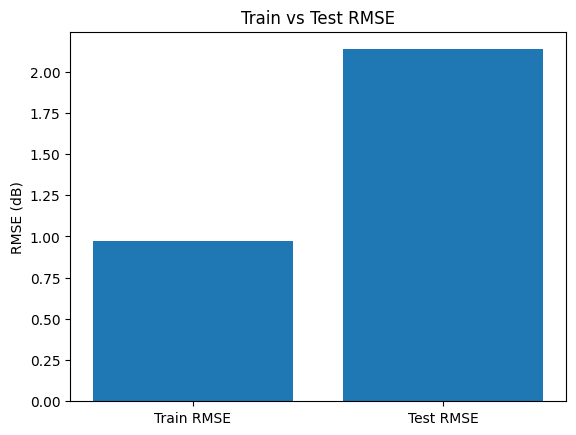

Train RMSE: 0.971696522648256
Test RMSE : 2.135733619390808


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ============================================================
# PURPOSE:
# Compare Train vs Test RMSE to check overfitting / underfitting.
#
# GOOD MODEL EXPECTATION:
# - Train and Test RMSE should be close.
# - Test RMSE slightly higher than Train is normal.
# - Very large gap -> Overfitting.
# - Both very high -> Underfitting.
# ============================================================

train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test))

plt.figure()
plt.bar(["Train RMSE", "Test RMSE"], [train_rmse, test_rmse])
plt.ylabel("RMSE (dB)")
plt.title("Train vs Test RMSE")
plt.show()

print("Train RMSE:", train_rmse)
print("Test RMSE :", test_rmse)

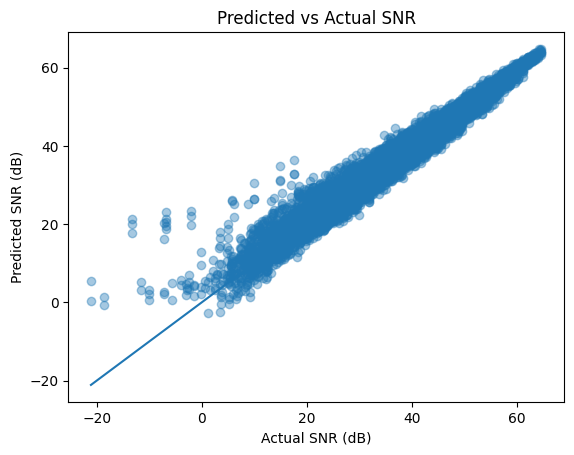

In [ ]:
# ============================================================
# PURPOSE:
# Check how well predicted SNR aligns with actual SNR.
#
# GOOD MODEL EXPECTATION:
# - Points tightly clustered around diagonal line.
# - No curved pattern (no systematic bias).
# - Minimal vertical spread (low variance).
#
# RED FLAG:
# - Wide scatter -> high prediction error.
# - Curved trend -> model bias.
# ============================================================

plt.figure()
plt.scatter(y_test, pred_test, alpha=0.4)
plt.xlabel("Actual SNR (dB)")
plt.ylabel("Predicted SNR (dB)")
plt.title("Predicted vs Actual SNR")

min_val = min(y_test.min(), pred_test.min())
max_val = max(y_test.max(), pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

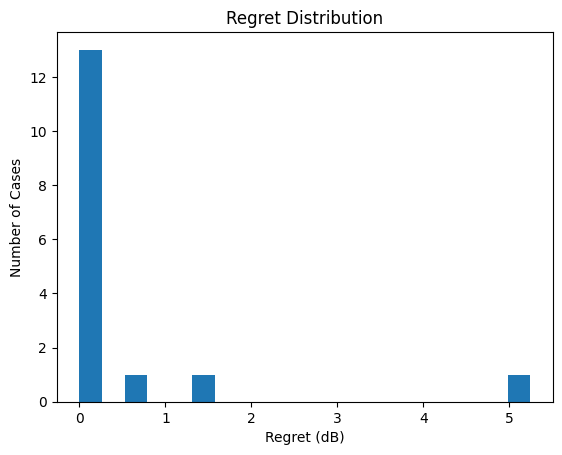

Average Regret: 0.4709592887499996
Median Regret : 0.0
Max Regret    : 5.24544229


In [ ]:
# ============================================================
# PURPOSE:
# Visualize distribution of regret (difference between optimal
# SNR and selected SNR).
#
# GOOD MODEL EXPECTATION:
# - Majority of cases near 0 dB.
# - Median regret ideally 0.
# - Very small long tail.
#
# RED FLAG:
# - Many cases above 2-3 dB.
# - Heavy tail -> unstable beam ranking.
# ============================================================

plt.figure()
plt.hist(regrets, bins=20)
plt.xlabel("Regret (dB)")
plt.ylabel("Number of Cases")
plt.title("Regret Distribution")
plt.show()

print("Average Regret:", np.mean(regrets))
print("Median Regret :", np.median(regrets))
print("Max Regret    :", np.max(regrets))

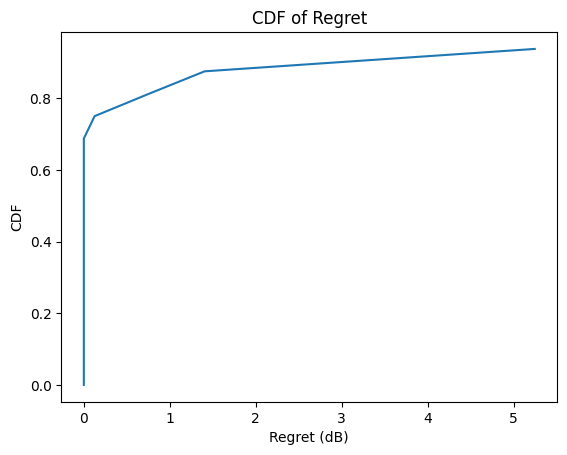

In [ ]:
# ============================================================
# PURPOSE:
# Show cumulative distribution of regret.
# This is a strong metric for beam selection systems.
#
# GOOD MODEL EXPECTATION:
# - Curve rises steeply near 0 dB.
# - 90-95% of cases should have low regret.
# - Smooth monotonic increase.
#
# RED FLAG:
# - Slow rise -> frequent mis-selections.
# ============================================================

sorted_regrets = np.sort(regrets)
cdf = np.arange(len(sorted_regrets)) / float(len(sorted_regrets))

plt.figure()
plt.plot(sorted_regrets, cdf)
plt.xlabel("Regret (dB)")
plt.ylabel("CDF")
plt.title("CDF of Regret")
plt.show()

<Figure size 640x480 with 0 Axes>

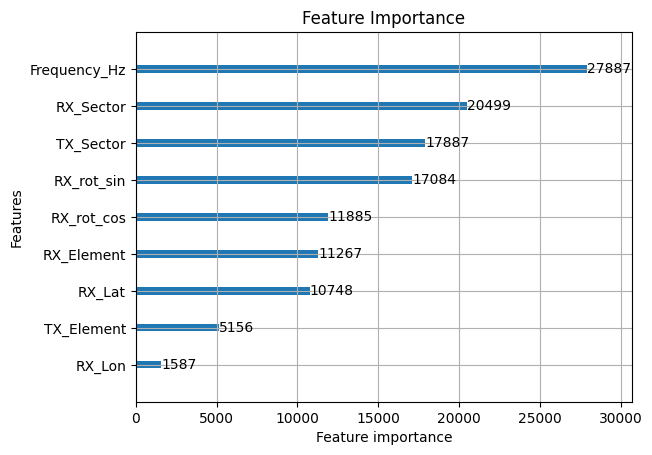

In [ ]:
import lightgbm as lgb

# ============================================================
# PURPOSE:
# Understand which features influence SNR prediction most.
#
# GOOD MODEL EXPECTATION:
# - Physically meaningful features (rotation, sector etc.)
#   should appear important.
# - Clear ranking between features.
#
# RED FLAG:
# - Irrelevant feature dominating -> possible data leakage.
# - All features equal importance -> weak learning.
# ============================================================

plt.figure()
lgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

Test scenarios: 16
Regret count : 16


/tmp/ipython-input-3422878666.py:43: FutureWarning: The provided callable <function mean at 0x7b1e0ebe1a80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = scenario_df.pivot_table(


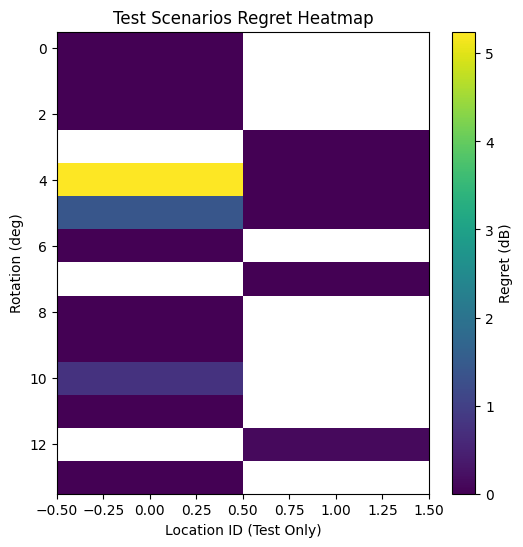

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# PURPOSE:
# Heatmap of regret across TEST scenarios only.
#
# NOTE:
# Since 80:20 group split was used,
# only ~16 scenarios are in test set.
#
# GOOD MODEL EXPECTATION:
# - Low regret values.
# - No strong rotation/location pattern even in unseen scenarios.
# ============================================================

X_temp = X_test.copy()

# Recover rotation
X_temp["Rotation_deg"] = np.degrees(
    np.arctan2(X_temp["RX_rot_sin"], X_temp["RX_rot_cos"])
)

# Extract test scenarios only
scenario_df = (
    X_temp[["RX_Lat", "RX_Lon", "Rotation_deg"]]
    .drop_duplicates()
    .sort_values(["RX_Lat", "RX_Lon", "Rotation_deg"])
    .reset_index(drop=True)
)

print("Test scenarios:", len(scenario_df))
print("Regret count :", len(regrets))

scenario_df["regret"] = regrets

# Compact location id
scenario_df["Location_ID"] = (
    scenario_df.groupby(["RX_Lat", "RX_Lon"]).ngroup()
)

pivot_table = scenario_df.pivot_table(
    values="regret",
    index="Rotation_deg",
    columns="Location_ID",
    aggfunc=np.mean
)

plt.figure(figsize=(6,6))
plt.imshow(pivot_table, aspect="auto")
plt.colorbar(label="Regret (dB)")
plt.xlabel("Location ID (Test Only)")
plt.ylabel("Rotation (deg)")
plt.title("Test Scenarios Regret Heatmap")
plt.show()

In [ ]:
print(X_test.columns)
print(len(regrets))

Index(['Tx_Lat', 'Tx_Lon', 'RX_Lat', 'RX_Lon', 'TX_Sector', 'TX_Element',
       'RX_Sector', 'RX_Element', 'Frequency_Hz', 'RX_rot_sin', 'RX_rot_cos'],
      dtype='object')
16


In [ ]:
#12222222222222222

# ==============================
# 1. Install library (run once)
# ==============================
!pip install ydata-profiling

# ==============================
# 2. Import libraries
# ==============================
import pandas as pd
from ydata_profiling import ProfileReport

# ==============================
# 3. Load your dataset
# ==============================
# Use the DATA_PATH defined earlier in the notebook
df = pd.read_csv(DATA_PATH)

# Preview data
print(df.shape)
print(df.head())

# ==============================
# 4. Generate Profiling Report
# ==============================
profile = ProfileReport(
    df,
    title="Antenna Dataset Profiling Report",
    explorative=True
)

# ==============================
# 5. Save report as HTML
# ==============================
profile.to_file("antenna_data_profile.html")

print("✅ Report generated: antenna_data_profile.html")

(102400, 12)
   S.No  Tx_Lat         Tx_Lon     RX_Lat     RX_Lon  RX_Rotation_deg  \
0     1   30.968764  76.474704  30.968895  76.474175                0   
1     2   30.968764  76.474704  30.968895  76.474175                0   
2     3   30.968764  76.474704  30.968895  76.474175                0   
3     4   30.968764  76.474704  30.968895  76.474175                0   
4     5   30.968764  76.474704  30.968895  76.474175                0   

   TX_Sector  TX_Element  RX_Sector  RX_Element  Frequency_Hz     SNR_dB  
0          1           1          1           1    5200000000  32.466354  
1          1           1          1           2    5200000000  34.716725  
2          1           1          2           1    5200000000  32.956479  
3          1           1          2           2    5200000000  28.512755  
4          1           1          3           1    5200000000  33.243552  


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:01<00:00,  7.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report generated: antenna_data_profile.html


In [ ]:
# ================================
# PURPOSE:
# Ensure group-level regret matches number of test groups.
# Good model expectation:
# Lengths should match. Regret length = number of test groups.
# ================================

import numpy as np

regrets_array = np.array(regrets)

print("Number of test groups:", len(test_groups))
print("Number of regrets:", len(regrets_array))

assert len(test_groups) == len(regrets_array), "Mismatch between groups and regrets!"
print("Structure Verified ✅")

Number of test groups: 16
Number of regrets: 16
Structure Verified ✅


In [ ]:
# ============================================
# PURPOSE:
# Identify worst-performing scenarios (group level).
# Good model expectation:
# Very few high regret cases.
# Worst regret should be rare and isolated.
# ============================================

top_k = 5

worst_indices = np.argsort(regrets_array)[-top_k:][::-1]

print("Top", top_k, "Worst Groups\n")

for rank, idx in enumerate(worst_indices, 1):
    print("="*50)
    print(f"Rank {rank}")
    print("Group Index:", idx)
    print("Group Key:", test_groups[idx])
    print("Regret:", regrets_array[idx])

Top 5 Worst Groups

Rank 1
Group Index: 3
Group Key: 30.968895_76.474175_72
Regret: 5.24544229
Rank 2
Group Index: 4
Group Key: 30.968895_76.474175_135
Regret: 1.4052450199999953
Rank 3
Group Index: 8
Group Key: 30.968895_76.474175_279
Regret: 0.7588039299999991
Rank 4
Group Index: 15
Group Key: 30.968907_76.474682_351
Regret: 0.12585737999999935
Rank 5
Group Index: 12
Group Key: 30.968907_76.474682_144
Regret: 0.0


In [ ]:
# ============================================
# PURPOSE:
# Deep inspect worst regret scenario.
# Good model expectation:
# Regret often due to near-equal beams
# or sector boundary confusion.
# ============================================

worst_idx = np.argmax(regrets_array)
worst_group = test_groups[worst_idx]

worst_case_df = test_df[test_df["group_key"] == worst_group].copy()

print("Worst Regret:", regrets_array[worst_idx])
print("Total beams in this scenario:", len(worst_case_df))

# Predict again for safety
worst_case_df["predicted_SNR"] = model.predict(worst_case_df[FEATURES])

# Actual best beam
actual_best_idx = worst_case_df["SNR_dB"].idxmax()
actual_best_row = worst_case_df.loc[actual_best_idx]

# Model selected beam
pred_best_idx = worst_case_df["predicted_SNR"].idxmax()
pred_best_row = worst_case_df.loc[pred_best_idx]

print("\nActual Best Beam SNR:", actual_best_row["SNR_dB"])
print("Model Selected Beam SNR:", pred_best_row["SNR_dB"])
print("Computed Regret:", actual_best_row["SNR_dB"] - pred_best_row["SNR_dB"])

print("\nActual Beam Sector:")
print(actual_best_row[["TX_Sector","RX_Sector"]])

print("\nPredicted Beam Sector:")
print(pred_best_row[["TX_Sector","RX_Sector"]])

Worst Regret: 5.24544229
Total beams in this scenario: 1280

Actual Best Beam SNR: 61.26386679
Model Selected Beam SNR: 56.0184245
Computed Regret: 5.24544229

Actual Beam Sector:
TX_Sector    3
RX_Sector    5
Name: 10684, dtype: object

Predicted Beam Sector:
TX_Sector    3
RX_Sector    4
Name: 10674, dtype: object


In [ ]:
# ============================================
# PURPOSE:
# Check if worst regret caused by small SNR gap.
# Good model expectation:
# Worst case often has small gap between top beams.
# ============================================

sorted_beams = worst_case_df.sort_values("SNR_dB", ascending=False)

print(sorted_beams[["SNR_dB","predicted_SNR"]].head(5))

top_gap = sorted_beams.iloc[0]["SNR_dB"] - sorted_beams.iloc[1]["SNR_dB"]

print("\nGap between best and second-best beam:", top_gap)

          SNR_dB  predicted_SNR
10684  61.263867      57.707671
10683  59.942472      56.526846
10524  59.750728      56.127854
10688  58.219563      55.179425
10681  58.034129      55.220530

Gap between best and second-best beam: 1.3213947799999985


In [ ]:
# ============================================
# PURPOSE:
# Check if worst case is near rotation boundary.
# Good model expectation:
# Worst errors often occur near sector boundaries.
# ============================================

import numpy as np

sin_val = actual_best_row["RX_rot_sin"]
cos_val = actual_best_row["RX_rot_cos"]

rotation_deg = np.degrees(np.arctan2(sin_val, cos_val)) % 360

print("Rotation (degrees approx):", rotation_deg)

Rotation (degrees approx): 72.0


In [ ]:
# ==============================
# RF SNR REGRESSION EVALUATION
# ==============================

import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

def evaluate_snr_model(y_true, y_pred, verbose=True):
    """
    Evaluation tailored for SNR regression in beam-selection systems.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # -----------------------
    # Core Regression Metrics
    # -----------------------

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # -----------------------
    # RF-Specific Diagnostics
    # -----------------------

    bias = np.mean(y_pred - y_true)          # Mean Bias Error
    max_error = np.max(np.abs(y_pred - y_true))

    # Adjusted R2
    n = len(y_true)
    p = 1   # since we don't know exact feature count here
    adj_r2 = 1 - (1 - r2)*(n - 1)/(n - p - 1)

    if verbose:
        print("\n===== RF SNR REGRESSION METRICS =====")
        print("MAE              :", mae)
        print("RMSE             :", rmse)
        print("R2               :", r2)
        print("Adjusted R2      :", adj_r2)
        print("Mean Bias Error  :", bias)
        print("Max Abs Error    :", max_error)
        print("======================================\n")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Adj_R2": adj_r2,
        "Bias": bias,
        "Max_Error": max_error
    }

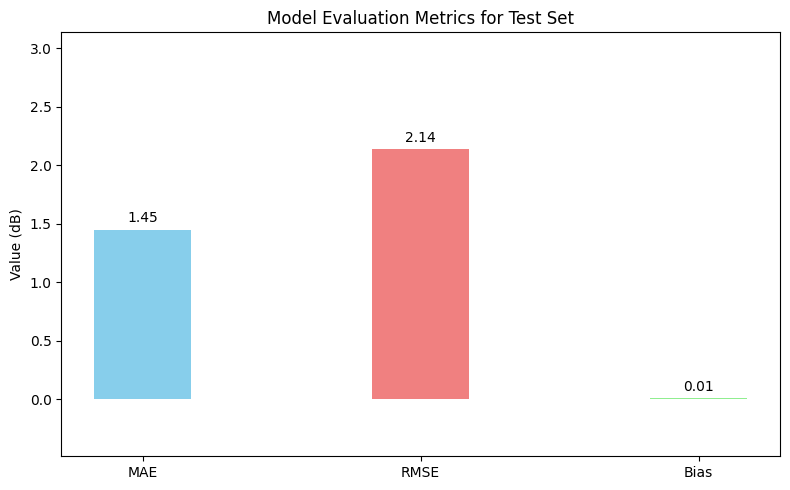

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from the test_metrics dictionary
metrics_to_plot = {
    'MAE': test_metrics['MAE'],
    'RMSE': test_metrics['RMSE'],
    'Bias': test_metrics['Bias']
}

labels = list(metrics_to_plot.keys())
values = list(metrics_to_plot.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x, values, width, color=['skyblue', 'lightcoral', 'lightgreen'])

ax.set_ylabel('Value (dB)')
ax.set_title('Model Evaluation Metrics for Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(bottom=min(0, min(values) - 0.5), top=max(values) + 1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.tight_layout()
plt.show()


In [ ]:
# Call the evaluation function for the test set
test_metrics = evaluate_snr_model(y_test, pred_test)
print("Test Set Metrics:")
print(test_metrics)

# Optionally, you can also evaluate the training set
# train_metrics = evaluate_snr_model(y_train, pred_train)
# print("\nTrain Set Metrics:")
# print(train_metrics)


===== RF SNR REGRESSION METRICS =====
MAE              : 1.4498521676827365
RMSE             : 2.135733619390808
R2               : 0.9627341325584424
Adjusted R2      : 0.9627323127582939
Mean Bias Error  : 0.01360432399131008
Max Abs Error    : 34.42308605620261

Test Set Metrics:
{'MAE': 1.4498521676827365, 'RMSE': np.float64(2.135733619390808), 'R2': 0.9627341325584424, 'Adj_R2': 0.9627323127582939, 'Bias': np.float64(0.01360432399131008), 'Max_Error': np.float64(34.42308605620261)}
